## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params, \
                                              jack_vae_template_3,jack_vae_template_1_bnormtest, jack_2_template
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder, PointNetVarAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'vae_bneck-100-withbrenormafter-3b'
train_dir = create_dir(osp.join(top_out_dir, experiment_name))
n_pc_points = 1000                # Number of points per model.
bneck_size = 100                # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'
#class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

Load Point-Clouds

In [5]:
import pandas as pd
numjets = 500000
numvalid = 50000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top_unnormalized_2.h5")
rawdata = outstore.select("points",stop=numjets).values
rawdata = rawdata.reshape(numjets,1000,2)
validdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
validdata = validdata.reshape(numvalid,1000,2)
all_pc_data = PointCloudDataSet(rawdata,copy=False)
valid_pc_data = PointCloudDataSet(validdata,copy=False)

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
train_params = default_train_params()
train_params['saver_step'] = 2
encoder, decoder, enc_args, dec_args = jack_vae_template_3(n_pc_points, bneck_size)


In [7]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args,
            beta = 0.0
           )
conf.experiment_name = experiment_name
conf.held_out_step = 1   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

Build AE Model.

In [8]:
reset_tf_graph()
ae = PointNetVarAutoEncoder(conf.experiment_name, conf)

Building Encoder
encoder_conv_layer_0 conv params =  384 Tensor("encoder_conv_layer_0_bnorm/batchnorm/add_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 Tensor("encoder_conv_layer_1_bnorm/batchnorm/add_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("Mean:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 Tensor("encoder_dense_layer_0_bnorm/batchnorm/add_1:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 Tensor("encoder_dense_layer_1_bnorm/batchnorm/add_1:0", shape=(?, 128), dtype=float32)
output size: 128 

[<tf.Tensor 'z_mean/BiasAdd:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'z_log_var/BiasAdd:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'z/add:0' shape=(?, 100) dtype=float32>]
Building Decoder
decoder_dense_layer_0 FC params =  12928 Tensor("vae_bneck-100-withbrenormafter-3b_2/decoder_dense_layer_0_bnorm/batch

Train the AE (save output to train_stats.txt) 

In [ ]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout,held_out_data=valid_pc_data)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '10.1718', 'loss=', '0.501655799')
INFO:tensorflow:../data/vae_bneck-100-withbrenormafter-3b/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Held Out Data :', 'forward time (minutes)=', '0.7191', 'loss=', '0.352366341')
('Epoch:', '0002', 'training time (minutes)=', '10.8254', 'loss=', '0.247204810')
INFO:tensorflow:../data/vae_bneck-100-withbrenormafter-3b/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.
('Held Out Data :', 'forward time (minutes)=', '0.7747', 'loss=', '0.224103082')
('Epoch:', '0003', 'training time (minutes)=', '10.9621', 'loss=', '0.247945181')
('Held Out Data :', 'forward time (minutes)=', '0.7854', 'loss=', '0.308355431')


In [ ]:
conf.beta = 600

In [ ]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout,held_out_data=valid_pc_data)
fout.close()

In [ ]:
load_pre_trained_ae = False
restore_epoch = 190
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetVarAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Get a batch of reconstuctions and their latent-codes.

In [ ]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

In [ ]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

numload = 50
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)


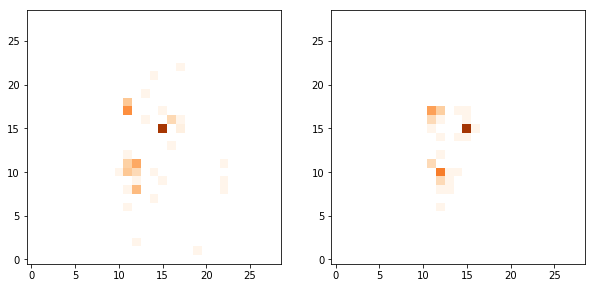

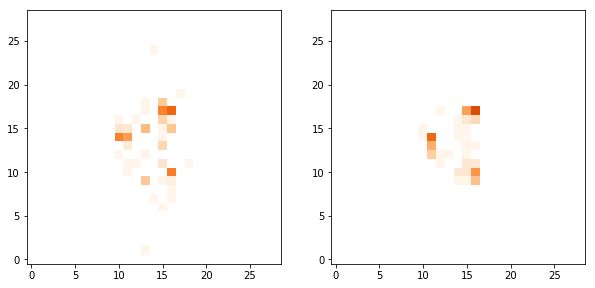

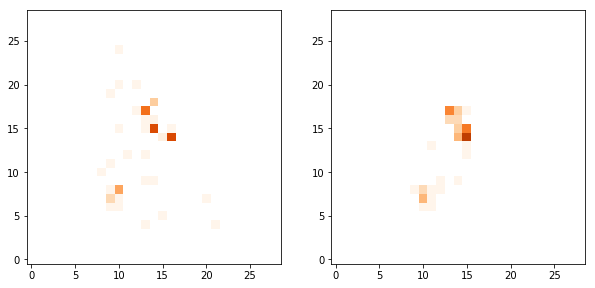

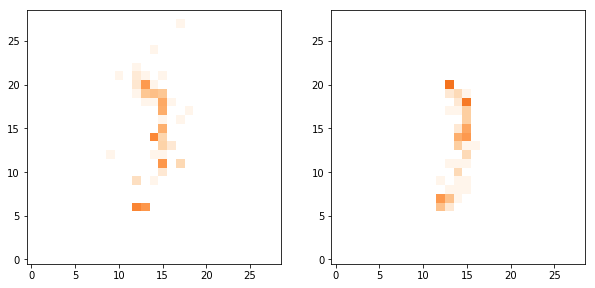

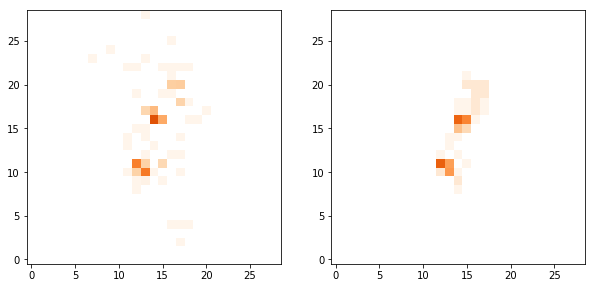

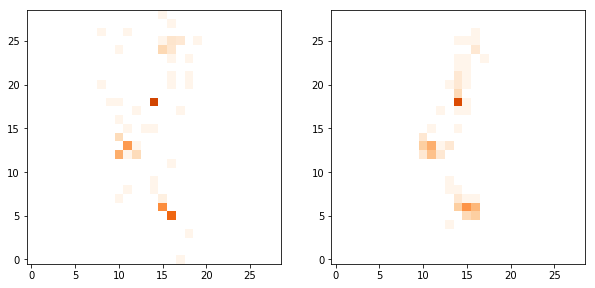

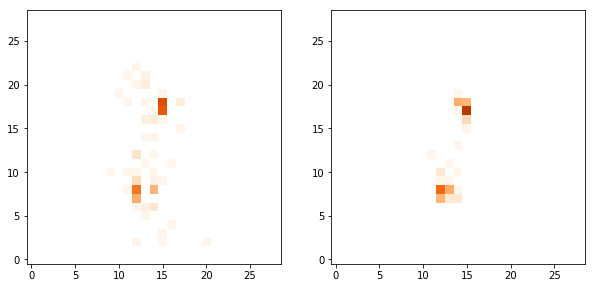

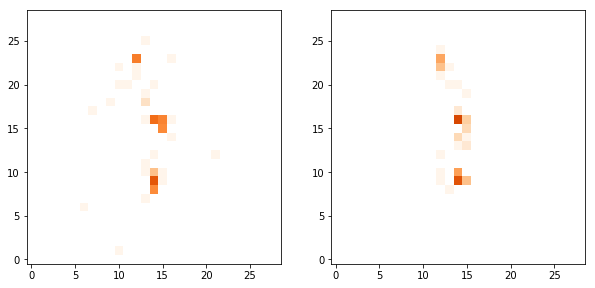

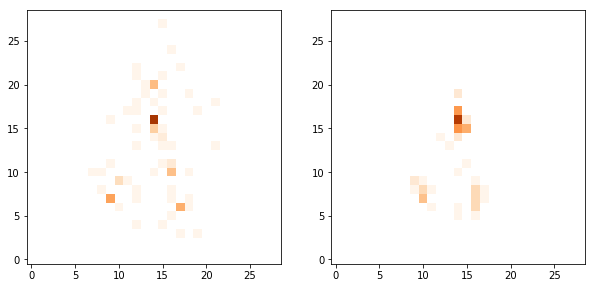

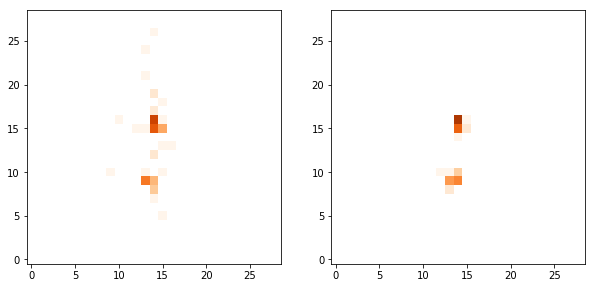

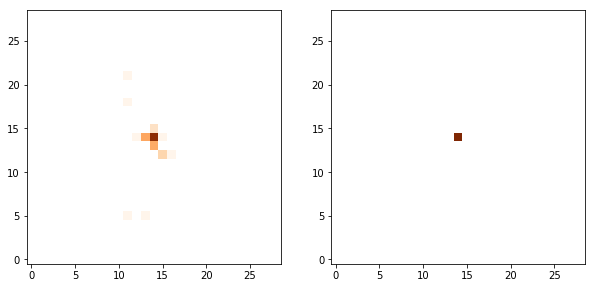

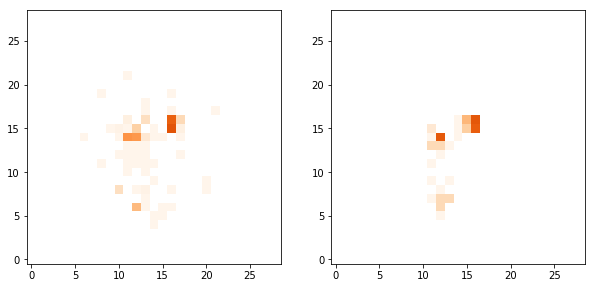

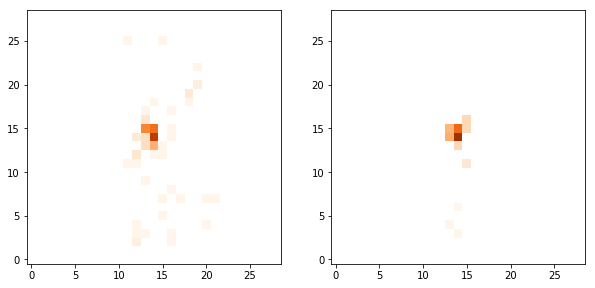

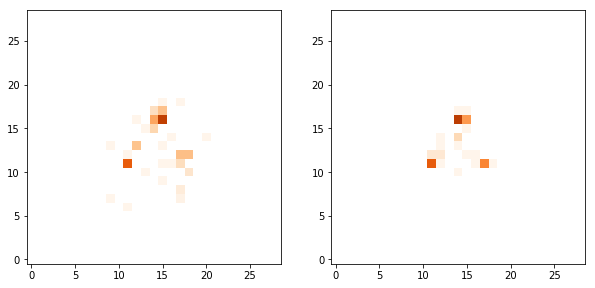

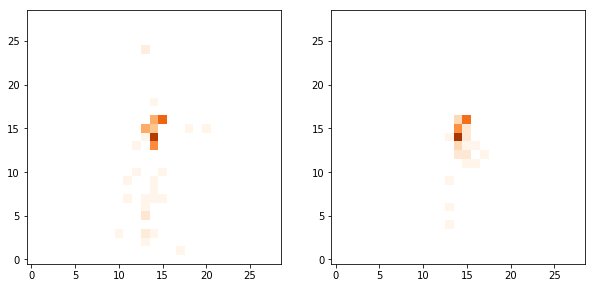

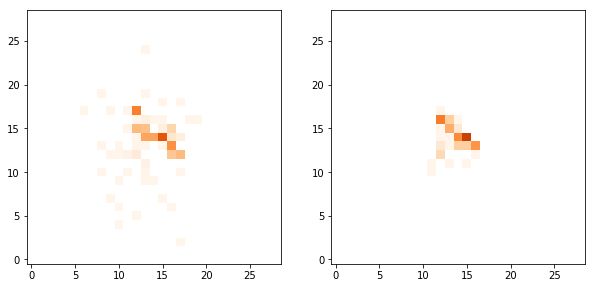

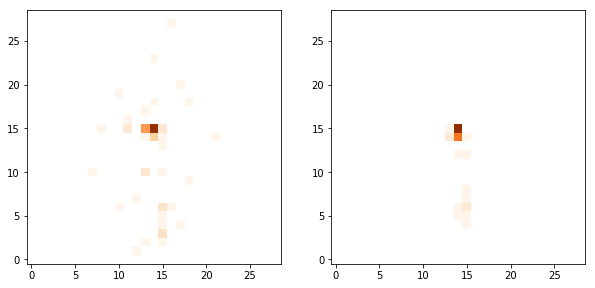

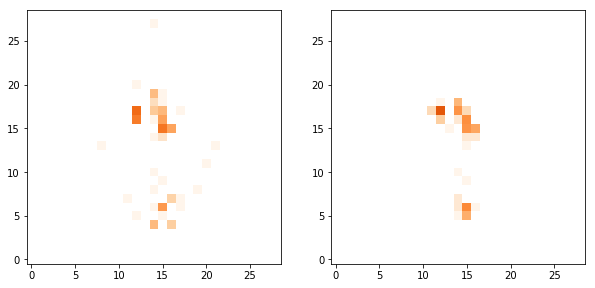

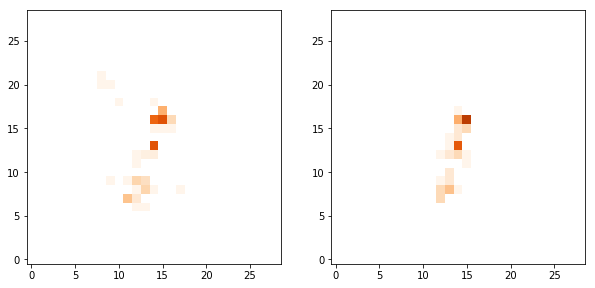

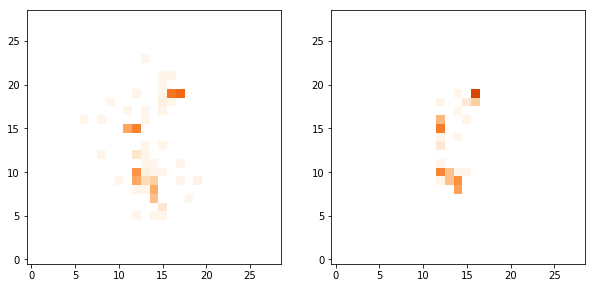

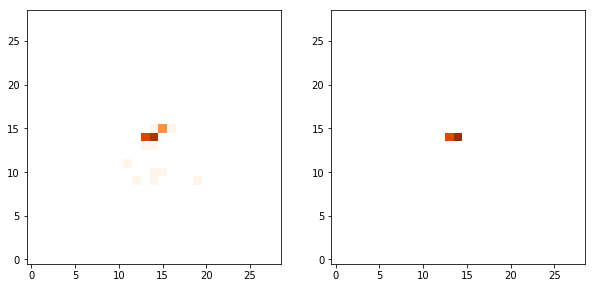

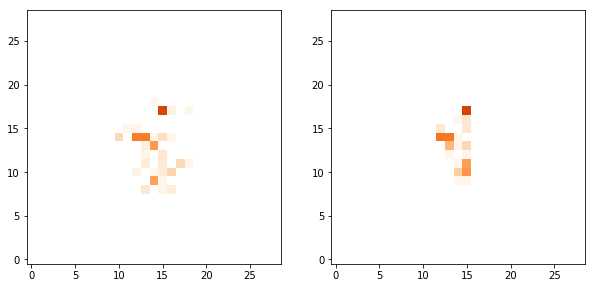

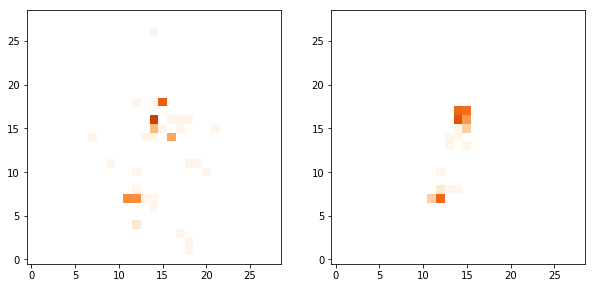

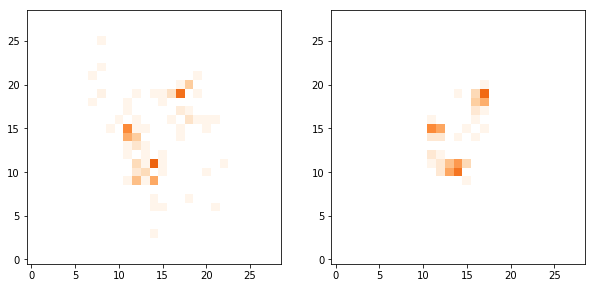

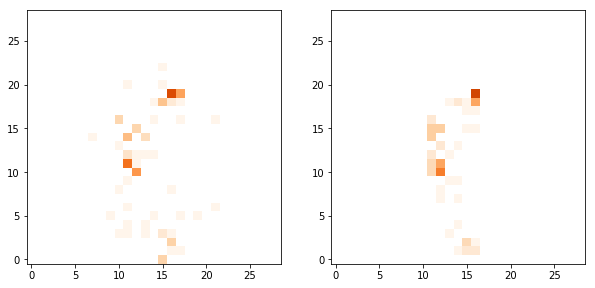

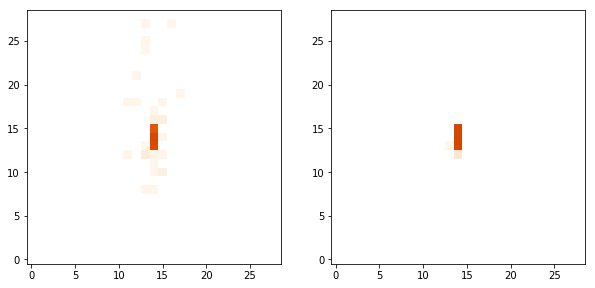

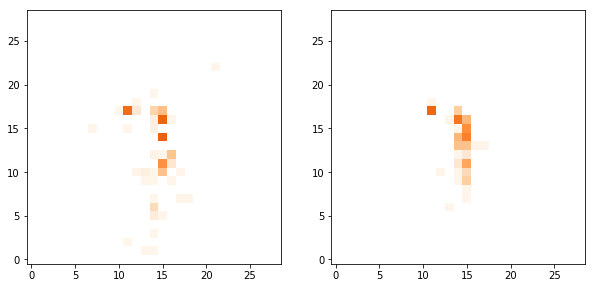

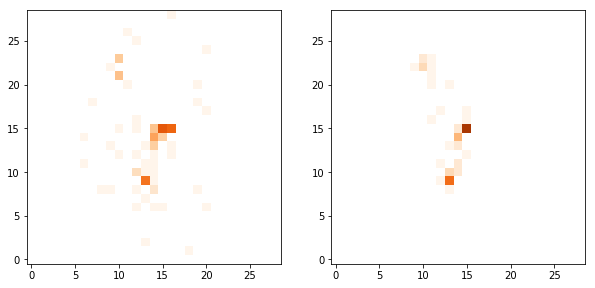

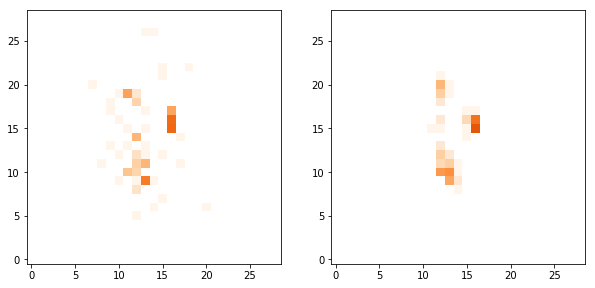

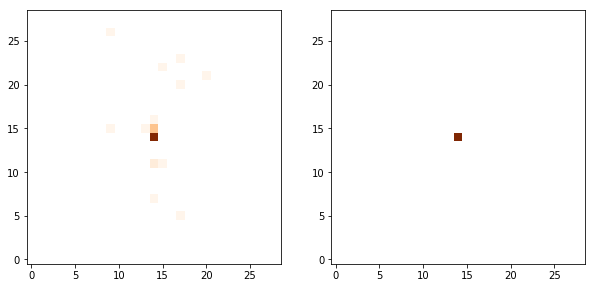

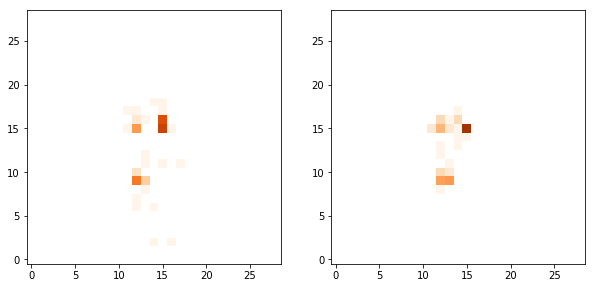

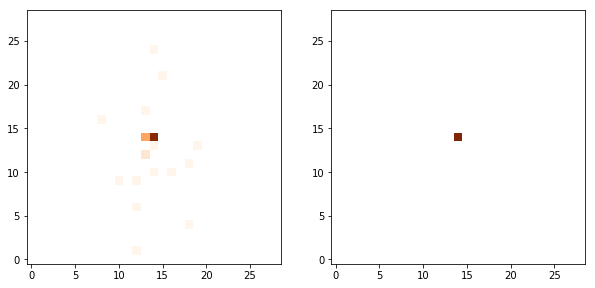

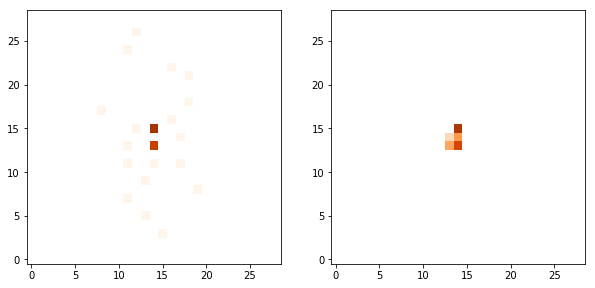

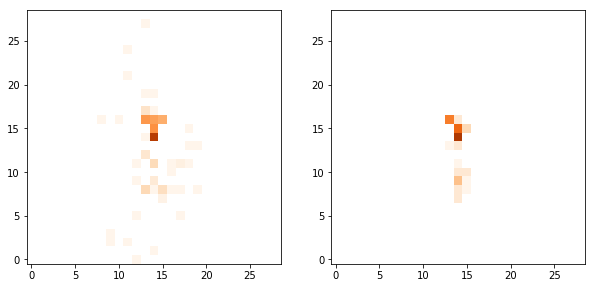

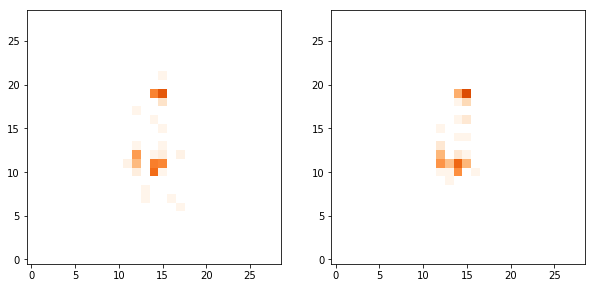

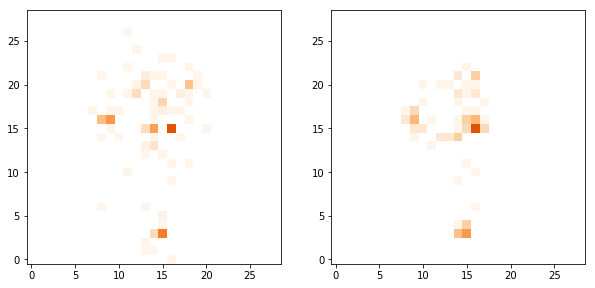

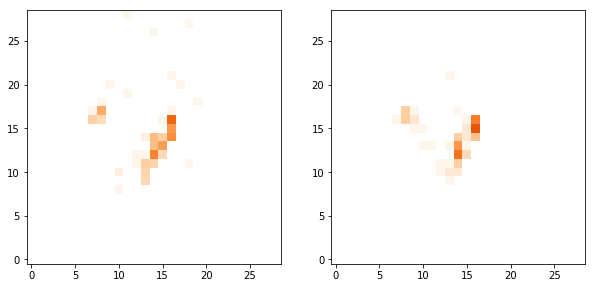

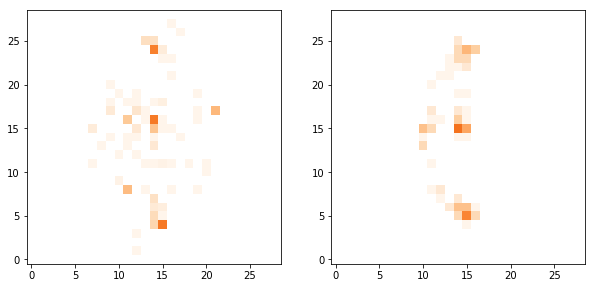

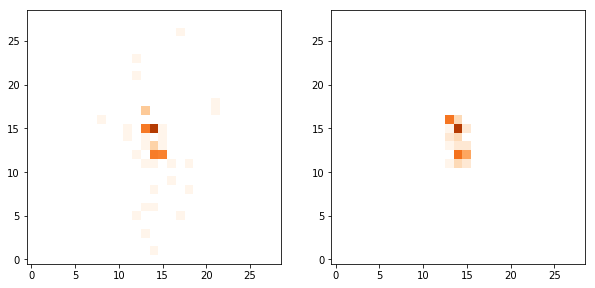

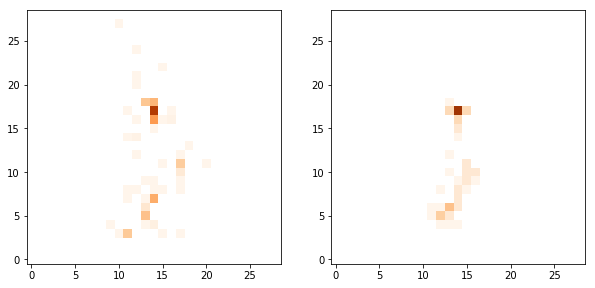

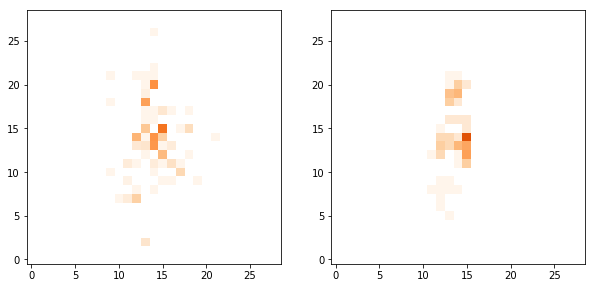

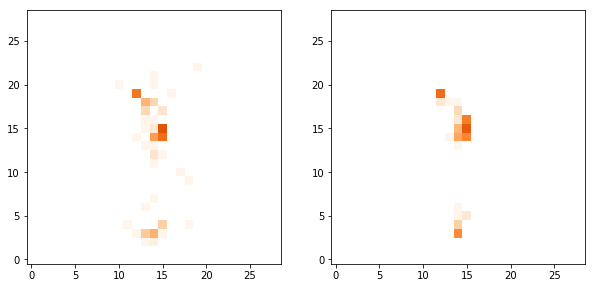

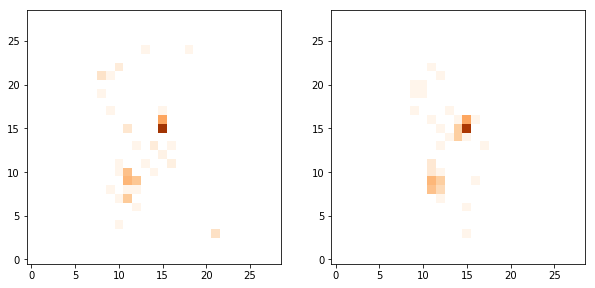

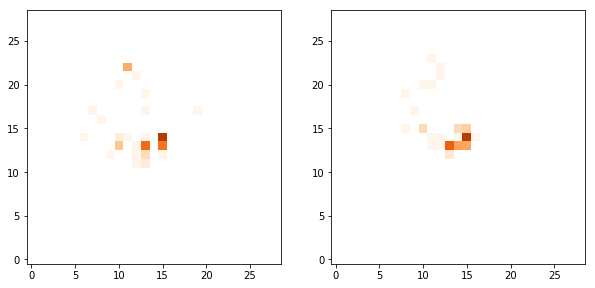

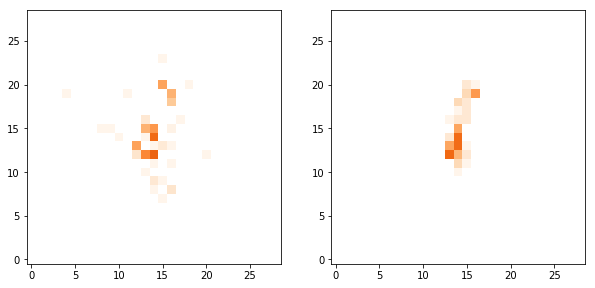

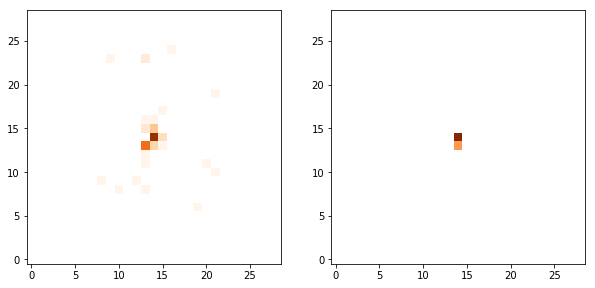

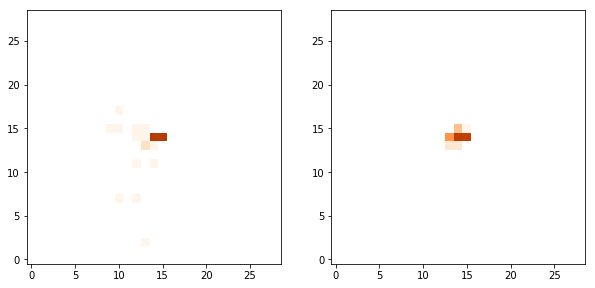

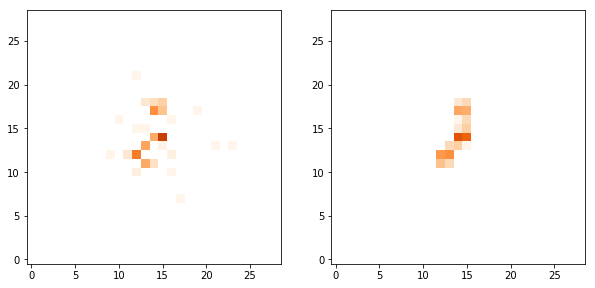

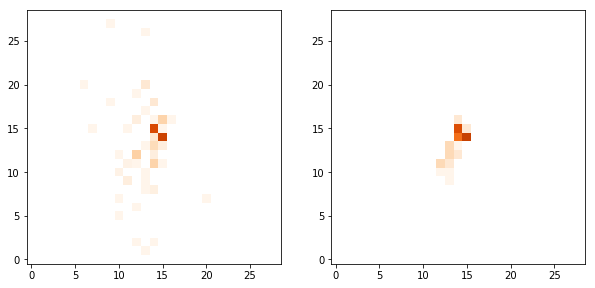

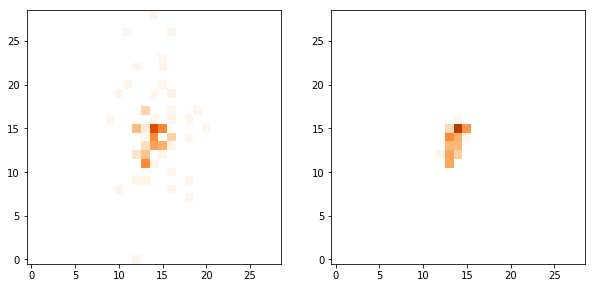

In [32]:
countcut=0.5
lim=1.5
bins=np.linspace(-lim, lim, 30)

for i in range(len(feed_pc)):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[0].imshow(counts.T , norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[1].imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [33]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch

nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = np.array(sess.run(this_cost))
    print cost
    
print time.time()-start

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[ 70.48385   86.821175 104.26028  105.937874 106.81725  136.61227
  75.60736   75.31395  108.086655  57.502983  35.797733  84.47954
 106.19676   59.22558   89.3427   105.517845  60.331688  76.72441
  64.02811   93.11118   37.262897  77.4644    78.22743  131.99652
  93.46692   59.290356 104.41791  108.3488   107.43253   38.586224
  58.591244  48.599403  38.239258  97.44197   68.56007  127.248665
  91.60281  152.72017   69.32378   77.60686  115.52972   72.55041
  79.14565   81.466705  81.864975  73.35875   39.099506  69.89478
 100.49957   98.49457 ]
17.0605387688


In [41]:
import ot
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])
print time.time()-start

6.67453598976


In [43]:
truecost

array([ 62.42499025,  71.08175966,  91.18473044,  83.4173391 ,
        84.04062587, 108.09255278,  65.25441521,  63.96611185,
        90.70324505,  48.11472411,  34.06294181,  74.24305679,
        91.28914299,  50.32756171,  71.83415568,  88.74789921,
        52.0478837 ,  67.23872307,  53.81332166,  82.05584467,
        34.73843906,  65.59258094,  67.58551329, 113.1545944 ,
        79.98495189,  52.47047656,  80.15731511,  90.11580117,
        86.20410058,  36.52284968,  50.21504384,  44.58144213,
        36.59000969,  81.61206463,  58.4200575 , 100.28258478,
        71.00884408, 136.89929361,  57.5229872 ,  67.40804307,
        91.86945007,  61.54936878,  65.13523924,  66.85468561,
        71.67903201,  69.15426914,  35.6796912 ,  57.18821681,
        85.2114116 ,  85.73458611])

In [42]:
print (cost - truecost)/truecost

[0.12909667 0.22142692 0.14339623 0.26997426 0.27101925 0.26384539
 0.1586551  0.1774039  0.19165146 0.19512237 0.050929   0.13787796
 0.16330112 0.17680206 0.24373561 0.18896161 0.15915737 0.14107478
 0.18981889 0.13472945 0.07267046 0.18099334 0.15745858 0.16651491
 0.16855629 0.12997555 0.30266224 0.20232855 0.24625781 0.05649543
 0.16680658 0.09012632 0.04507373 0.19396527 0.17357067 0.26890093
 0.29001978 0.11556579 0.2051491  0.15129966 0.25754227 0.1787352
 0.21509729 0.21856388 0.14210492 0.06079856 0.09584767 0.22218854
 0.17941448 0.1488312 ]


In [40]:
truecost

array([0.02381326, 0.01963535, 0.01269321, 0.02102361, 0.01707547,
       0.01771693, 0.02326995, 0.00922827, 0.01382505, 0.00709923,
       0.00059158, 0.00914449, 0.00493771, 0.01271564, 0.00327961,
       0.00385209, 0.00508147, 0.01202511, 0.00985956, 0.0173615 ,
       0.00103453, 0.01353902, 0.01077689, 0.0176966 , 0.01960065,
       0.00182791, 0.01679961, 0.00488535, 0.00896678, 0.00086407,
       0.01203948, 0.0010284 , 0.00396729, 0.0053785 , 0.01982924,
       0.02908025, 0.00687423, 0.02346291, 0.00402473, 0.02500645,
       0.0179361 , 0.03156714, 0.01561063, 0.00453036, 0.00519127,
       0.00051943, 0.0010376 , 0.00691612, 0.00419736, 0.0046264 ])